In [1]:
!pip install ninja

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 6.5 MB/s eta 0:00:00


In [2]:
import torch

torch.manual_seed(42)
N, K, M = 2, 32, 64
bits = 4

weight_fp16 = torch.randn(M, K) # [Out, In]

# scale과 zeropoint 임의로 설정
"""
    qweight_int: [Output, Input] 형태의 INT4 가중치
    scales: [Output, 1(Group)] 형태의 FP16 스케일
    zeros: [Output, 1(Group)] 형태의 Zero-point
"""

w_min = weight_fp16.min(dim = 1, keepdim=True)[0]
w_max = weight_fp16.max(dim = 1, keepdim=True)[0]

scales = (w_max - w_min) / 15

zero_point = torch.round(-1 * w_min / scales)
zero_point = torch.clamp(zero_point, 0, 15)

qweight_int4 = torch.clamp(torch.round(weight_fp16 / scales + zero_point), 0, 15)

print(f"원본 크기 : {weight_fp16.shape}")
print(f"int4 가중치 크기 : {qweight_int4.shape}")

def preprocess_optq_to_bcq(w_int4, scale, zero, bits = 4):

    """
    입력:
      w_int4: [Out, In] (0~15 값)
      scale:  [Out, 1]
      zero:   [Out, 1]
    출력:
      alphas: [Out, 1, Bits] (비트별 스케일)
      bias:   [Out, 1]       (보정된 Bias)
    """

    alphas = []
    for i in range(bits):
        alpha_idx = scale * (2 ** (i - 1))
        alphas.append(alpha_idx)

    alphas = torch.stack(alphas, dim = -1) # [Out, 1, bits]

    bias_orig = -1.0 * scales * zero

    bias_shift = 0
    for i in range(bits):
        bias_shift += scale * (2 ** (i - 1))

    bias = bias_orig + bias_shift

    return alphas, bias

# 테스트 실행
bcq_alphas, bcq_bias = preprocess_optq_to_bcq(qweight_int4, scales, zero_point, bits=bits)

w_recon = torch.zeros_like(weight_fp16)

for i in range(bits):
    bit_val = (qweight_int4.int() // (2**i)) % 2
    bcq_bit = bit_val * 2 - 1

    w_recon += bcq_bit * bcq_alphas[..., i]

w_recon += bcq_bias

target_recon = scales * (qweight_int4 - zero_point)

#오차
error = (target_recon - w_recon).abs().max()
print(f"복원 오차: {error.item():.8f}")


원본 크기 : torch.Size([64, 32])
int4 가중치 크기 : torch.Size([64, 32])
복원 오차: 0.00000048


In [3]:
from torch.utils.cpp_extension import load_inline

cuda_source = """
/*
lut-gemm 간단하게 구현해보기

    input A : [N, K] (fp32 라고 가정)
    weight B : [K, M] (int4가 int32에 담겨있다고 가정)
    output C : [N, M]
    alpha : [bits, M]

*/

#include <cuda_runtime.h>

__global__ void lut_gemm(
    const float* A,
    const int* B,
    float* C,
    const float* alpha,
    int N, int K, int M
) {

    int row = blockIdx.y; // N ( batch 전체)
    int col = blockIdx.x * blockDim.x + threadIdx.x; // M
    int tid = threadIdx.x;


    // mu = 4 라고 가정
    __shared__ float lut[16];// (이런 식으로 하면 노는 스레드가 발생할 수 있으나 어차피 간략하게 테스트 용이니 나중에 생각 )

    float acc = 0.0f; // ALU

    // 논문에서는 K_TILE_SIZE = 32 이지만 현재 코드에서는 K 전체를 4개 씩 타일링 해서 처리
    for (int k = 0; k < K; k+=4){

        if (tid < 16){
            /*
            Optimization:
                데이터를 하나씩 가져오지 말고 int4로 여러개 같고와서 공유메모리에 저장하기(공유 메모리가 남는다면)
                reinterpret_cast 사용 가능
            */
            float a0 = (k + 0 < K) ? A[row * K + (k + 0)] : 0.0f;
            float a1 = (k + 1 < K) ? A[row * K + (k + 1)] : 0.0f;
            float a2 = (k + 2 < K) ? A[row * K + (k + 2)] : 0.0f;
            float a3 = (k + 3 < K) ? A[row * K + (k + 3)] : 0.0f;

            float pattern_sum =     + (2 * ((tid >> 0) & 1) - 1) * a0
                                    + (2 * ((tid >> 1) & 1) - 1) * a1
                                    + (2 * ((tid >> 2) & 1) - 1) * a2
                                    + (2 * ((tid >> 3) & 1) - 1) * a3;

            lut[tid] = pattern_sum;

        }

        __syncthreads();

        if (col < M) {
            // 가중치가 패킹이 안되어 있다고 가정
            int b0 = (k + 0 < K) ? B[(k + 0) * M + col] : 0;
            int b1 = (k + 1 < K) ? B[(k + 1) * M + col] : 0;
            int b2 = (k + 2 < K) ? B[(k + 2) * M + col] : 0;
            int b3 = (k + 3 < K) ? B[(k + 3) * M + col] : 0;

            for (int b=0; b < 4; ++b) {
                // 각 가중치 b번째 비트
                int bit0 = (b0 >> b) & 1;
                int bit1 = (b1 >> b) & 1;
                int bit2 = (b2 >> b) & 1;
                int bit3 = (b3 >> b) & 1;

                int pattern_idx = (bit3 << 3) | (bit2 << 2) | (bit1 << 1) | bit0;

                /*
                Optimization:
                    alpha를 사용 할 때마다 글로벌 메모리에 접근하게 하지 말고
                    루프 이전에 알파를 레지스터로 이동
                */
                acc += lut[pattern_idx] * alpha[b * M + col];
            }
        }
        __syncthreads();
    }

    if (col < M && row < N) {
        C[row * M + col] = acc;
    }
}
"""


cpp_source = "torch::Tensor run_lut_gemm(torch::Tensor A, torch::Tensor B, torch::Tensor Alpha);"

# 래퍼 함수
cuda_wrapper = """
torch::Tensor run_lut_gemm(torch::Tensor A, torch::Tensor B, torch::Tensor Alpha) {
    int N = A.size(0);
    int K = A.size(1);
    int M = B.size(1); // Weight [K, M]

    auto C = torch::zeros({N, M}, A.options());

    // Block: 128 threads handling M dimension
    dim3 block(128, 1);

    dim3 grid((M + 127) / 128, N);

    lut_gemm<<<grid, block>>>(
        A.data_ptr<float>(),
        B.data_ptr<int>(),
        C.data_ptr<float>(),
        Alpha.data_ptr<float>(),
        N, K, M
    );
    return C;
}
"""
full_cuda_source = cuda_source + cuda_wrapper

lut_module = load_inline(
    name='lut_gemm',
    cpp_sources=cpp_source,
    cuda_sources=full_cuda_source,
    functions=['run_lut_gemm'],
    with_cuda=True,
    extra_cuda_cflags=["-O2"]
)

In [4]:
# 테스트 데이터
device = 'cuda'
A = torch.randn(N, K).to(device)

# B는 가중치 [K, M]. 실제로는 4비트 패킹되어야 하지만 여기선 0~15 정수라고 가정
B_quant = qweight_int4.T.contiguous().to(dtype=torch.int32).to(device)

alpha = bcq_alphas.squeeze(1).T.contiguous().to(device)

w_recon_no_bias = (w_recon - bcq_bias).to(device)

expected = torch.matmul(A, w_recon_no_bias.T)

# 커널 실행
output_lut = lut_module.run_lut_gemm(A, B_quant, alpha)

# 오차 확인
diff = (expected - output_lut).abs().max()
print(f"LUT-GEMM 오차: {diff.item():.8f}")

if diff < 1e-4:
    print("Shared Memory LUT 구현 성공!")
else:
    print(" 오차 발생 확인 필요")

LUT-GEMM 오차: 0.00000286
Shared Memory LUT 구현 성공!


In [10]:
from torch.utils.cpp_extension import load_inline

cuda_source = """
/*
lut-gemm 간단하게 구현해보기

    input A : [N, K] (fp32 라고 가정)
    weight B : [K, M] (int4가 int32에 담겨있다고 가정)
    output C : [N, M]
    alpha : [bits, M]

*/

#include <cuda_runtime.h>

__global__ void lut_gemm_profile(
    const float* A,
    const int* B,
    float* C,
    const float* alpha,
    int N, int K, int M,
    unsigned long long* debug_lut_cycles,
    unsigned long long* debug_compute_cycles
) {

    int row = blockIdx.y; // N ( batch 전체)
    int col = blockIdx.x * blockDim.x + threadIdx.x; // M
    int tid = threadIdx.x;


    // mu = 4 라고 가정
    __shared__ float lut[16];// (이런 식으로 하면 노는 스레드가 발생할 수 있으나 어차피 간략하게 테스트 용이니 나중에 생각 )

    float acc = 0.0f; // ALU

    // 로컬 카운터
    unsigned long long local_lut_time = 0;
    unsigned long long local_compute_time = 0;

    // 논문에서는 K_TILE_SIZE = 32 이지만 현재 코드에서는 K 전체를 4개 씩 타일링 해서 처리
    for (int k = 0; k < K; k+=4){

        // 측정
        long long t0 = clock64();

        if (tid < 16){
            /*
            Optimization:
                데이터를 하나씩 가져오지 말고 int4로 여러개 같고와서 공유메모리에 저장하기(공유 메모리가 남는다면)
                reinterpret_cast 사용 가능
            */
            float a0 = (k + 0 < K) ? A[row * K + (k + 0)] : 0.0f;
            float a1 = (k + 1 < K) ? A[row * K + (k + 1)] : 0.0f;
            float a2 = (k + 2 < K) ? A[row * K + (k + 2)] : 0.0f;
            float a3 = (k + 3 < K) ? A[row * K + (k + 3)] : 0.0f;

            float pattern_sum =     + (2 * ((tid >> 0) & 1) - 1) * a0
                                    + (2 * ((tid >> 1) & 1) - 1) * a1
                                    + (2 * ((tid >> 2) & 1) - 1) * a2
                                    + (2 * ((tid >> 3) & 1) - 1) * a3;

            lut[tid] = pattern_sum;

        }

        __syncthreads();

        // 분기점
        long long t1 = clock64();

        if (col < M) {
            // 가중치가 패킹이 안되어 있다고 가정
            int b0 = (k + 0 < K) ? B[(k + 0) * M + col] : 0;
            int b1 = (k + 1 < K) ? B[(k + 1) * M + col] : 0;
            int b2 = (k + 2 < K) ? B[(k + 2) * M + col] : 0;
            int b3 = (k + 3 < K) ? B[(k + 3) * M + col] : 0;

            for (int b=0; b < 4; ++b) {
                // 각 가중치 b번째 비트
                int bit0 = (b0 >> b) & 1;
                int bit1 = (b1 >> b) & 1;
                int bit2 = (b2 >> b) & 1;
                int bit3 = (b3 >> b) & 1;

                int pattern_idx = (bit3 << 3) | (bit2 << 2) | (bit1 << 1) | bit0;

                /*
                Optimization:
                    alpha를 사용 할 때마다 글로벌 메모리에 접근하게 하지 말고
                    루프 이전에 알파를 레지스터로 이동
                */
                acc += lut[pattern_idx] * alpha[b * M + col];
            }
        }
        __syncthreads();

        // 종료
        long long t2 = clock64();

        // tid == 0 일 때, 대표로 측정
        // 워프 내 실행 흐름은 같으니
        if (tid == 0) {
            local_lut_time += t1 - t0;
            local_compute_time += t2 - t1;
        }
    }

    if (col < M && row < N) {
        C[row * M + col] = acc;
    }

    // 결과 합
    if (tid == 0) {
        atomicAdd(debug_lut_cycles, local_lut_time);
        atomicAdd(debug_compute_cycles, local_compute_time);
    }

}
"""


cpp_source = """torch::Tensor run_lut_profile(torch::Tensor A, torch::Tensor B, torch::Tensor Alpha,
                                        torch::Tensor debug_lut, torch::Tensor debug_compute);
                                        """

# 래퍼 함수
cuda_wrapper = """
torch::Tensor run_lut_profile(torch::Tensor A, torch::Tensor B, torch::Tensor Alpha,
                          torch::Tensor debug_lut, torch::Tensor debug_compute)  {
    int N = A.size(0);
    int K = A.size(1);
    int M = B.size(1); // Weight [K, M]

    auto C = torch::zeros({N, M}, A.options());

    // Block: 128 threads handling M dimension
    dim3 block(128, 1);

    dim3 grid((M + 127) / 128, N);

    lut_gemm_profile<<<grid, block>>>(
        A.data_ptr<float>(),
        B.data_ptr<int>(),
        C.data_ptr<float>(),
        Alpha.data_ptr<float>(),
        N, K, M,
        (unsigned long long*)debug_lut.data_ptr(),
        (unsigned long long*)debug_compute.data_ptr()
    );
    return C;
}
"""
full_cuda_source = cuda_source + cuda_wrapper

lut_profile = load_inline(
    name='lut_gemm_profile',
    cpp_sources=cpp_source,
    cuda_sources=full_cuda_source,
    functions=['run_lut_profile'],
    with_cuda=True,
    extra_cuda_cflags=["-O2"]
)

Batch      | LUT Cycles      | Comp Cycles     | LUT Ratio (%)  
-----------------------------------------------------------------
1          | 1758            | 2859            | 38.08%
16         | 27800           | 45682           | 37.83%
32         | 55788           | 93084           | 37.47%
64         | 115109          | 199837          | 36.55%
128        | 242237          | 399455          | 37.75%
256        | 543818          | 832835          | 39.50%
512        | 1151178         | 1579432         | 42.16%
1024       | 2419782         | 3174314         | 43.26%


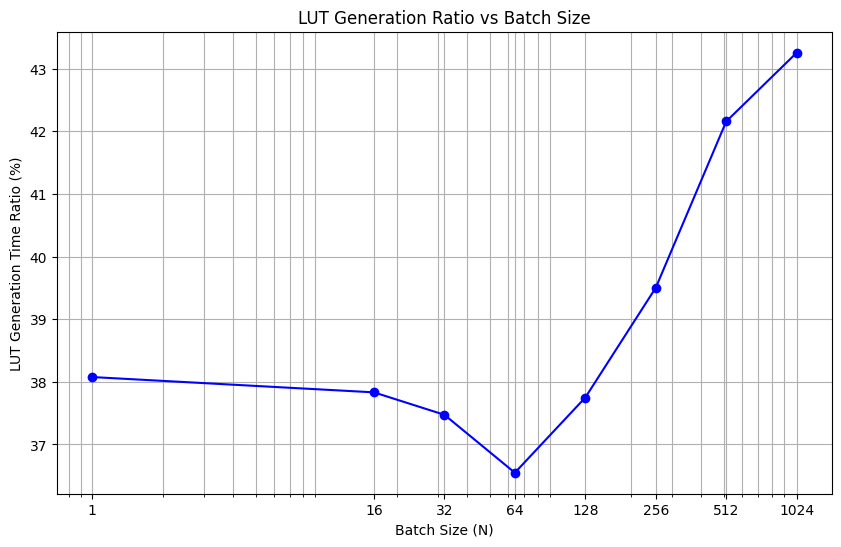

In [21]:
import matplotlib.pyplot as plt

batch_sizes = [1, 16, 32, 64, 128, 256, 512, 1024]
lut_ratios = []
lut_times = []
compute_times = []

print(f"{'Batch':<10} | {'LUT Cycles':<15} | {'Comp Cycles':<15} | {'LUT Ratio (%)':<15}")
print("-" * 65)

for N in batch_sizes:
    A = torch.randn(N, K).to(device)

    # 디버그 카운터 초기화
    debug_lut = torch.zeros(1, dtype=torch.int64, device=device)
    debug_compute = torch.zeros(1, dtype=torch.int64, device=device)

    # 웜업
    lut_profile.run_lut_profile(A, B_quant, alpha, debug_lut, debug_compute)

    # 측정
    debug_lut.zero_()
    debug_compute.zero_()

    lut_profile.run_lut_profile(A, B_quant, alpha, debug_lut, debug_compute)
    torch.cuda.synchronize()

    l_time = debug_lut.item()
    c_time = debug_compute.item()

    total = l_time + c_time
    ratio = (l_time / total) * 100 if total > 0 else 0

    lut_ratios.append(ratio)
    lut_times.append(l_time)
    compute_times.append(c_time)

    print(f"{N:<10} | {l_time:<15} | {c_time:<15} | {ratio:.2f}%")

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, lut_ratios, marker='o', linestyle='-', color='b')
plt.xscale('log')
plt.xlabel('Batch Size (N)')
plt.xticks(batch_sizes, labels=batch_sizes)
plt.ylabel('LUT Generation Time Ratio (%)')
plt.title('LUT Generation Ratio vs Batch Size')
plt.grid(True, which="both", ls="-")
plt.show()